In [1]:
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import ast
from openai import OpenAI
client = OpenAI()


# import df

In [2]:
def string_to_list(s):
    if (pd.isna(s)) or (s==''):
        return np.nan 
    
    # Use ast.literal_eval to safely evaluate string representations of lists
    try:
        parsed_list = ast.literal_eval(s)
    except (ValueError, SyntaxError):
        # Fallback in case of any parsing errors
        parsed_list = s.strip('[]').split(',')

    # Strip any extra whitespace and quotes
    return [item.strip().strip('"').strip("'") for item in parsed_list]

In [3]:
df = pd.read_csv('../Input/books_data.csv',
                       converters={
    'categories': string_to_list}, 
    ).dropna(subset='categories')
print(df.shape)

df = df.explode('categories')
print(df.shape)
df.head()

(171205, 10)
(171205, 10)


,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,Comics & Graphic Novels,NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,Biography & Autobiography,NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,Religion,NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,Fiction,NaN
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,Religion,5.0


# Get embbedings

In [4]:
categories = df['categories'].unique()

In [16]:

# Function to save embeddings and strings to files
def save_embeddings_and_strings(batch_index, batch_categories, embeddings):
    output_dir = "/home/mateus/Work/PageLens/Output/embeddings/category"
    
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save embeddings to a file
    embeddings_file = os.path.join(output_dir, f"embeddings_batch_{batch_index}.pkl")
    with open(embeddings_file, 'wb') as f:
        pickle.dump(embeddings, f)
    
    # Save batch categories to a file
    strings_file = os.path.join(output_dir, f"batch_{batch_index}_strings.pkl")
    with open(strings_file, 'wb') as f:
        pickle.dump(batch_categories, f)

# Process categories in batches of 500
batch_size = 500
for i in range(0, len(categories), batch_size):
    batch_categories = categories[i:i + batch_size]
    
    # Generate embeddings for the batch
    response = client.embeddings.create(input=batch_categories, model="text-embedding-3-small").data
    
    # Save embeddings and batch strings
    save_embeddings_and_strings(i // batch_size, batch_categories, response)

print("Processing complete.")


Processing complete.


# Clustering

In [5]:


def load_embeddings(embedding_dir):
    embeddings = {}
    for file_name in os.listdir(embedding_dir):
        if file_name.startswith("embeddings_batch_") and file_name.endswith(".pkl"):
            # Extract batch index from the file name
            batch_index = file_name.split("_")[2].split(".")[0]
            
            # Load the corresponding categories
            strings_file = os.path.join(embedding_dir, f"batch_{batch_index}_strings.pkl")
            with open(strings_file, 'rb') as f:
                batch_categories = pickle.load(f)
            
            # Load the embeddings
            embeddings_file = os.path.join(embedding_dir, file_name)
            with open(embeddings_file, 'rb') as f:
                batch_embeddings = pickle.load(f)
            
            # Store embeddings with corresponding categories
            for category, embedding in zip(batch_categories, batch_embeddings):
                embeddings[category] = embedding
    
    return embeddings

# Example usage:
embeddings_dir = "/home/mateus/Work/PageLens/Output/embeddings/category"
embeddings = load_embeddings(embeddings_dir)


In [6]:

all_categories = df['categories'].to_list()
# Create a matrix of embeddings weighted by category frequency
embedding_matrix = []
for category in all_categories:
    if category in embeddings:
        weighted_embedding = embeddings[category].embedding
        embedding_matrix.append(weighted_embedding)

embedding_matrix = np.array(embedding_matrix)


In [7]:
# Apply PCA to reduce dimensions to 2D
pca = PCA(n_components=2)
embedding_2d_pca = pca.fit_transform(embedding_matrix)
df['x_axis'], df['y_axis'] =embedding_2d_pca[:, 0], embedding_2d_pca[:, 1]


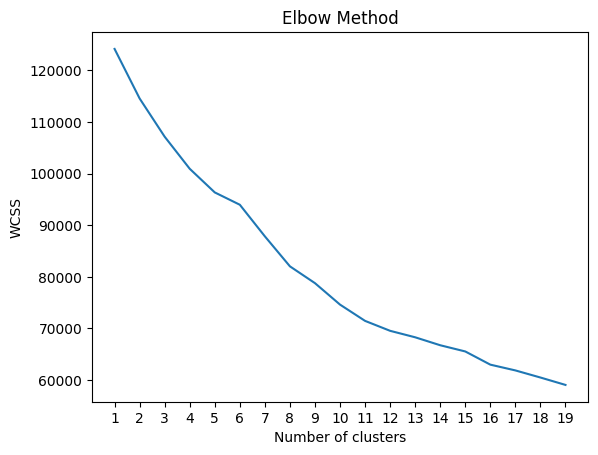

In [8]:
wcss = []
for i in range(1, 20):  # Test a range of n_clusters
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(embedding_matrix)
    wcss.append(kmeans.inertia_)

# Plot the WCSS to visualize the "elbow"
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.xticks(range(1,20))
plt.ylabel('WCSS')
plt.show()

In [8]:
# Apply clustering (KMeans in this case)
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(embedding_matrix)

pca_centroids = pca.transform(kmeans.cluster_centers_)
# Map cluster labels back to categories
clustered_categories = pd.DataFrame({
    'category': all_categories,
    'cluster': clusters,
})

df['cluster'] = clusters


In [9]:
for i in range(11):
    print(i)
    print(df[df['cluster']==i]['categories'].value_counts().head(5))
    print()
    print('____')

0
categories
Cooking                2445
Sports & Recreation    2267
Travel                 1812
Reference              1277
Transportation          921
Name: count, dtype: int64

____
1
categories
Literary Criticism             2147
Music                          2106
Art                            2054
Language Arts & Disciplines    2036
Philosophy                     1864
Name: count, dtype: int64

____
2
categories
Fiction               23419
Fantasy fiction          57
FICTION                  51
Fiction in English       38
Historical fiction       28
Name: count, dtype: int64

____
3
categories
Social Science            3834
Science                   2623
Political Science         1955
Psychology                1913
Foreign Language Study    1404
Name: count, dtype: int64

____
4
categories
Religion        9459
Christianity      79
Religions         13
RELIGION          12
Faith             10
Name: count, dtype: int64

____
5
categories
History            9330
Education         

In [10]:
cluster_name_dict ={0: 'Travel',
                    1: 'Art',
                    2: 'Fiction',
                    3: 'Social Science',
                    4: 'Religion',
                    5: 'History',
                    6: 'Juvenile Nonfiction',
                    7: 'Body, Mind & Spirit',
                    8: 'Biography',
                    9: 'Computers',
                    10: 'Business & Economics'}

In [11]:
df['cluster_name'] = df['cluster'].map(cluster_name_dict)
df.to_parquet('../Input/bookes_data_category_clustered.parquet')
df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,x_axis,y_axis,cluster,cluster_name
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,Comics & Graphic Novels,NaN,0.044563,-0.298286,1,Art
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,Biography & Autobiography,NaN,-0.070939,-0.392944,8,Biography
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,Religion,NaN,-0.168683,0.635882,4,Religion
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,Fiction,NaN,0.687696,0.131479,2,Fiction
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,Religion,5.0,-0.168683,0.635882,4,Religion
